Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 12.5 MB/s 
     |████████████████████████████████| 6.6 MB 79.7 MB/s 
     |████████████████████████████████| 120 kB 81.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=3862056f8722c3911c880e6fe251ea0850c8a49d937abf8143ac026f65354497
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1hIe1NaUcYENwTFrG_z1WUEiEkEzhtzbx'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1fbR_cCVnnvMiJuaS7tvGE8nHHepciFuG'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1cz6lxw3dd-zeoKtLewT7pjSkIIh4BjOe'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  226
Number of dev sentences:  40
Number of test sentences:  48
Number of words in the training dataset:  5862
Number of words in the dev dataset:  1874
Number of words in the test dataset:  2030
Tags in the training dataset: ['B-PARTY', 'I-DOC_NAME', 'I-PARTY', 'B-AGMT_DATE', 'B-DOC_NAME', 'I-AGMT_DATE', 'O']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-PARTY', 'I-DOC_NAME', 'I-PARTY', 'B-AGMT_DATE', 'B-DOC_NAME', 'I-AGMT_DATE', 'O']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['B-PARTY', 'I-DOC_NAME', 'I-PARTY', 'B-AGMT_DATE', 'B-DOC_NAME', 'I-AGMT_DATE', 'O']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Exhibit,O
1,Sentence: 1,99.1,O
2,Sentence: 1,JOINT,B-DOC_NAME
3,Sentence: 1,FILING,I-DOC_NAME
4,Sentence: 1,AGREEMENT,I-DOC_NAME
5,Sentence: 1,The,O
6,Sentence: 1,undersigned,O
7,Sentence: 1,hereby,O
8,Sentence: 1,agree,O
9,Sentence: 1,that,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Exhibit', 'O'),
 ('10.8', 'O'),
 ('Services', 'B-DOC_NAME'),
 ('Agreement', 'I-DOC_NAME'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('and', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 ('(', 'I-PARTY'),
 ('International', 'I-PARTY'),
 (')', 'I-PARTY'),
 ('Limited', 'I-PARTY'),
 ('September', 'O'),
 ('2018', 'O'),
 ('1', 'O'),
 ('THIS', 'O'),
 ('SERVICES', 'B-DOC_NAME'),
 ('AGREEMENT', 'I-DOC_NAME'),
 ('(', 'O'),
 ('this', 'O'),
 ('“', 'O'),
 ('Agreement', 'O'),
 ('”', 'O'),
 (')', 'O'),
 ('is', 'O'),
 ('made', 'O'),
 ('on', 'O'),
 ('25', 'B-AGMT_DATE'),
 ('September', 'I-AGMT_DATE'),
 ('2018', 'I-AGMT_DATE'),
 ('BETWEEN', 'O'),
 (':', 'O'),
 ('(', 'O'),
 ('1', 'O'),
 (')', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('a', 'O'),
 ('Delaware', 'O'),
 ('limited', 'O'),
 ('partnership', 'O

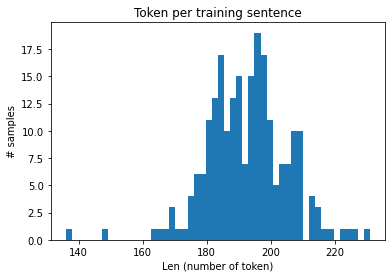

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

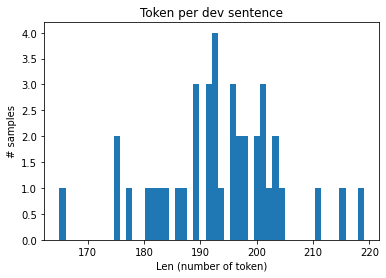

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

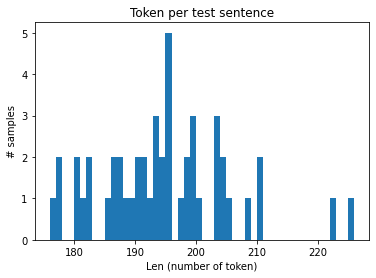

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'business'
print(word2idx['business'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-PARTY'
print(tag2idx['B-PARTY'])
# Tag of index 2
print(idx2tag[2])

3871
forms
0
I-PARTY


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.33628)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 226
Points in y_train before removal: 226
Points in X_train before removal: 150
Points in y_train before removal: 150


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[5777, 4641, 6626, 4901, 1300, 5723, 6502, 1525, 5877, 7066, 1046, 133, 3257, 4840, 1295, 133, 4094, 1514, 604, 2429, 3604, 6367, 3244, 4063, 4072, 2429, 7092, 271, 1148, 4722, 3416, 4836, 2918, 4063, 4072, 7092, 5458, 2918, 5028, 133, 423, 6914, 4957, 3121, 3235, 5564, 3254, 4722, 1472, 2429, 6968, 3845, 984, 3528, 6727, 5869, 2096, 6727, 486, 2419, 3854, 2602, 1054, 558, 1210, 6337, 896, 2163, 3618, 133, 644, 6934, 3200, 2941, 5869, 2096, 3200, 486, 2419, 558, 4207, 2941, 5869, 2096, 4207, 486, 2419, 5869, 2602, 2096, 6337, 486, 2419, 5252, 6021, 2254, 3544, 2150, 4636, 2328, 5608, 4957, 7176, 2059, 3200, 558, 4207, 311, 5635, 3854, 523, 6238, 5872, 3854, 2602, 980, 3470, 558, 2834, 3854, 3591, 1004, 558, 5176, 5872, 311, 6635, 7141, 768, 2954, 3854, 2602, 3553, 558, 915, 6536, 577, 6873, 2145, 2602, 1352, 2590, 1778, 3854, 3809, 6621, 4636, 2602, 6337, 133, 3200, 558, 4207, 311, 1113, 5635, 3854, 5222, 6758, 2602, 4524, 3238, 2024, 6732, 5912, 3522, 1533, 4869, 1615, 558, 3854, 7077

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 15.4 MB/s 
     |████████████████████████████████| 120 kB 55.9 MB/s 
     |████████████████████████████████| 6.6 MB 71.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=26d4f1f173c6da86ecabc3bca8cf888a15a542de7ebb57a7a3fb3da30e2164b7
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[5777, 4641, 6626, 4901, 1300, 5723, 6502, 1525, 5877, 706

In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [9]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9526424407958984
Training loss epoch: 0.5993887265523274
Training accuracy epoch: 0.8240334036063947
Validating model...
Validation Loss: 0.2518533691763878
Validation Accuracy: 0.9235031732444243
Training epoch: 2
Training loss per 100 training steps: 0.2433842569589615
Training loss epoch: 0.2077973594268163
Training accuracy epoch: 0.9345543060833784
Validating model...
Validation Loss: 0.14655033126473427
Validation Accuracy: 0.9554193464634312
Training epoch: 3
Training loss per 100 training steps: 0.17578914761543274
Training loss epoch: 0.1015964870651563
Training accuracy epoch: 0.9705306489920703
Validating model...
Validation Loss: 0.10138100385665894
Validation Accuracy: 0.9706842193712868
Training epoch: 4
Training loss per 100 training steps: 0.0773482546210289
Training loss epoch: 0.05320479149619738
Training accuracy epoch: 0.9857578328058818
Validating model...
Validation Loss: 0.07583955023437738
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06435311585664749
Validation Accuracy: 0.9835944303535484
Validation duration: 0.007993199999999945 minutes
F1-score (test): 84.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.87      0.93      0.90        82
       PARTY       0.74      0.88      0.80       122

   micro avg       0.80      0.89      0.84       254
   macro avg       0.82      0.89      0.85       254
weighted avg       0.80      0.89      0.84       254

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.7297247648239136
Training loss epoch: 0.5226777404546737
Training accuracy epoch: 0.8481852154812717
Validating model...
Validation Loss: 0.18643732368946075
Validation Accuracy: 0.9330667780462883
Training epoch: 2
Training loss per 100 training steps: 0.24847412109375
Training loss epoch: 0.1509779880444209
Training accuracy epoch: 0.9528621724160405
Validating model...
Validation Loss: 0.10220515541732311
Validation Accuracy: 0.9714578903201277
Training epoch: 3
Training loss per 100 training steps: 0.1072656512260437
Training loss epoch: 0.08122545455892881
Training accuracy epoch: 0.9772902874177879
Validating model...
Validation Loss: 0.0801738416776061
Validation Accuracy: 0.9767643293898591
Training epoch: 4
Training loss per 100 training steps: 0.06751660257577896
Training loss epoch: 0.0517666249225537
Training accuracy epoch: 0.9860668779336154
Validating model...
Validation Loss: 0.0705775273963809
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0680217295885086
Validation Accuracy: 0.9816993590216263
Validation duration: 0.008020716666666771 minutes
F1-score (test): 85.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.92      0.90        50
    DOC_NAME       0.84      0.93      0.88        82
       PARTY       0.77      0.87      0.82       122

   micro avg       0.82      0.90      0.86       254
   macro avg       0.83      0.91      0.87       254
weighted avg       0.82      0.90      0.86       254

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.1296842098236084
Training loss epoch: 0.5734067519505819
Training accuracy epoch: 0.8251471771230311
Validating model...
Validation Loss: 0.20975907891988754
Validation Accuracy: 0.9317789535269423
Training epoch: 2
Training loss per 100 training steps: 0.23045937716960907
Training loss epoch: 0.17080009529987972
Training accuracy epoch: 0.9441723779416481
Validating model...
Validation Loss: 0.1276273913681507
Validation Accuracy: 0.9555968171441304
Training epoch: 3
Training loss per 100 training steps: 0.09731654077768326
Training loss epoch: 0.09296062688032786
Training accuracy epoch: 0.9713211114078302
Validating model...
Validation Loss: 0.08946165442466736
Validation Accuracy: 0.9757183507749512
Training epoch: 4
Training loss per 100 training steps: 0.08313118666410446
Training loss epoch: 0.052558125307162605
Training accuracy epoch: 0.9868641435814045
Validating model...
Validation Loss: 0.0905951177701354
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06715707890689374
Validation Accuracy: 0.983669656792509
Validation duration: 0.009237966666666845 minutes
F1-score (test): 86.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.94      0.90        50
    DOC_NAME       0.89      0.93      0.91        82
       PARTY       0.79      0.86      0.82       122

   micro avg       0.84      0.90      0.87       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.84      0.90      0.87       254

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9043564796447754
Training loss epoch: 0.6087672531604766
Training accuracy epoch: 0.826237580632764
Validating model...
Validation Loss: 0.23782937973737717
Validation Accuracy: 0.9224942252476847
Training epoch: 2
Training loss per 100 training steps: 0.2759089469909668
Training loss epoch: 0.18281393299500148
Training accuracy epoch: 0.9383321391254451
Validating model...
Validation Loss: 0.1320182830095291
Validation Accuracy: 0.9532152148614972
Training epoch: 3
Training loss per 100 training steps: 0.1476888656616211
Training loss epoch: 0.09713450173536936
Training accuracy epoch: 0.9717618948515141
Validating model...
Validation Loss: 0.09888036176562309
Validation Accuracy: 0.9722165519595213
Training epoch: 4
Training loss per 100 training steps: 0.05081581324338913
Training loss epoch: 0.05580568934480349
Training accuracy epoch: 0.9866853382263305
Validating model...
Validation Loss: 0.06903215032070875
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07191906422376633
Validation Accuracy: 0.984134848755083
Validation duration: 0.007901116666666515 minutes
F1-score (test): 84.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.90      0.91        50
    DOC_NAME       0.91      0.94      0.92        82
       PARTY       0.74      0.82      0.78       122

   micro avg       0.83      0.87      0.85       254
   macro avg       0.85      0.89      0.87       254
weighted avg       0.83      0.87      0.85       254

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.8874174356460571
Training loss epoch: 0.6416921993096669
Training accuracy epoch: 0.8257535839291523
Validating model...
Validation Loss: 0.28704458847641945
Validation Accuracy: 0.9044686248972047
Training epoch: 2
Training loss per 100 training steps: 0.3261297047138214
Training loss epoch: 0.20645895302295686
Training accuracy epoch: 0.9368596365286953
Validating model...
Validation Loss: 0.13291263952851295
Validation Accuracy: 0.9586261138460414
Training epoch: 3
Training loss per 100 training steps: 0.1209355965256691
Training loss epoch: 0.0982175921400388
Training accuracy epoch: 0.9702266268654429
Validating model...
Validation Loss: 0.08101796824485064
Validation Accuracy: 0.9752442850143178
Training epoch: 4
Training loss per 100 training steps: 0.05892496928572655
Training loss epoch: 0.05866259063283603
Training accuracy epoch: 0.9846605642331255
Validating model...
Validation Loss: 0.07604773622006178
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0615016832947731
Validation Accuracy: 0.9867823139692071
Validation duration: 0.007983283333333209 minutes
F1-score (test): 87.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.92      0.91        50
    DOC_NAME       0.87      0.91      0.89        82
       PARTY       0.82      0.88      0.85       122

   micro avg       0.85      0.90      0.88       254
   macro avg       0.87      0.90      0.88       254
weighted avg       0.85      0.90      0.88       254

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.2710988521575928
Training loss epoch: 0.668195350964864
Training accuracy epoch: 0.8138375559350481
Validating model...
Validation Loss: 0.23451517894864082
Validation Accuracy: 0.9239583020052834
Training epoch: 2
Training loss per 100 training steps: 0.24844487011432648
Training loss epoch: 0.18088950763146083
Training accuracy epoch: 0.9444859618520546
Validating model...
Validation Loss: 0.1267255563288927
Validation Accuracy: 0.9650103206021844
Training epoch: 3
Training loss per 100 training steps: 0.0926479622721672
Training loss epoch: 0.07950834234555562
Training accuracy epoch: 0.9791854956254549
Validating model...
Validation Loss: 0.0913799125701189
Validation Accuracy: 0.9721966734042771
Training epoch: 4
Training loss per 100 training steps: 0.03456434607505798
Training loss epoch: 0.05169003307819366
Training accuracy epoch: 0.9864660465540674
Validating model...
Validation Loss: 0.07476669177412987
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07466925084590911
Validation Accuracy: 0.9837656034429987
Validation duration: 0.007921633333333488 minutes
F1-score (test): 87.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.92      0.90        50
    DOC_NAME       0.89      0.93      0.91        82
       PARTY       0.80      0.90      0.85       122

   micro avg       0.85      0.91      0.88       254
   macro avg       0.86      0.92      0.89       254
weighted avg       0.85      0.91      0.88       254

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.1288609504699707
Training loss epoch: 0.623149170478185
Training accuracy epoch: 0.8144881421285107
Validating model...
Validation Loss: 0.2482796534895897
Validation Accuracy: 0.9196586105943733
Training epoch: 2
Training loss per 100 training steps: 0.2976212799549103
Training loss epoch: 0.20315175155798595
Training accuracy epoch: 0.9353154306246885
Validating model...
Validation Loss: 0.13556267693638802
Validation Accuracy: 0.9632022742808624
Training epoch: 3
Training loss per 100 training steps: 0.11625352501869202
Training loss epoch: 0.11071938772996266
Training accuracy epoch: 0.9673563931048116
Validating model...
Validation Loss: 0.11309434473514557
Validation Accuracy: 0.9681633600498634
Training epoch: 4
Training loss per 100 training steps: 0.07895029336214066
Training loss epoch: 0.062182760487000145
Training accuracy epoch: 0.9841542373174915
Validating model...
Validation Loss: 0.07231746893376112
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06382239535450936
Validation Accuracy: 0.9820208339322678
Validation duration: 0.007899566666666639 minutes
F1-score (test): 80.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.92      0.89        50
    DOC_NAME       0.74      0.85      0.80        82
       PARTY       0.74      0.82      0.78       122

   micro avg       0.77      0.85      0.81       254
   macro avg       0.78      0.86      0.82       254
weighted avg       0.77      0.85      0.81       254

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.800646424293518
Training loss epoch: 0.5544859210650126
Training accuracy epoch: 0.8398102664719542
Validating model...
Validation Loss: 0.20753096789121628
Validation Accuracy: 0.929754225130976
Training epoch: 2
Training loss per 100 training steps: 0.1743985116481781
Training loss epoch: 0.19155032833417257
Training accuracy epoch: 0.9386295735076715
Validating model...
Validation Loss: 0.12177561782300472
Validation Accuracy: 0.9608225856212735
Training epoch: 3
Training loss per 100 training steps: 0.09611281752586365
Training loss epoch: 0.09604974960287412
Training accuracy epoch: 0.9720992964268824
Validating model...
Validation Loss: 0.088773381896317
Validation Accuracy: 0.9733606129972235
Training epoch: 4
Training loss per 100 training steps: 0.056828971952199936
Training loss epoch: 0.05014918918410937
Training accuracy epoch: 0.9872845735100513
Validating model...
Validation Loss: 0.06600131932646036
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06558802425861358
Validation Accuracy: 0.9827200298294008
Validation duration: 0.007881949999999922 minutes
F1-score (test): 86.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.89      0.94      0.91        50
    DOC_NAME       0.90      0.90      0.90        82
       PARTY       0.79      0.87      0.83       122

   micro avg       0.84      0.89      0.87       254
   macro avg       0.86      0.90      0.88       254
weighted avg       0.85      0.89      0.87       254

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9148941040039062
Training loss epoch: 0.5902541448672612
Training accuracy epoch: 0.8280510410849757
Validating model...
Validation Loss: 0.20582452788949013
Validation Accuracy: 0.9299038215465624
Training epoch: 2
Training loss per 100 training steps: 0.23135057091712952
Training loss epoch: 0.173938749730587
Training accuracy epoch: 0.9454698492285664
Validating model...
Validation Loss: 0.09818486869335175
Validation Accuracy: 0.9724465386575373
Training epoch: 3
Training loss per 100 training steps: 0.10440006852149963
Training loss epoch: 0.0841607908407847
Training accuracy epoch: 0.9778777995797457
Validating model...
Validation Loss: 0.07752750348299742
Validation Accuracy: 0.9772394812694245
Training epoch: 4
Training loss per 100 training steps: 0.05151631683111191
Training loss epoch: 0.04580356640120347
Training accuracy epoch: 0.988231535452995
Validating model...
Validation Loss: 0.0686657065525651
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06189813539385795
Validation Accuracy: 0.9848956054166459
Validation duration: 0.007948233333333594 minutes
F1-score (test): 87.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.96      0.94      0.95        50
    DOC_NAME       0.90      0.93      0.92        82
       PARTY       0.78      0.88      0.82       122

   micro avg       0.85      0.91      0.88       254
   macro avg       0.88      0.91      0.90       254
weighted avg       0.85      0.91      0.88       254

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9653517007827759
Training loss epoch: 0.6823409577210744
Training accuracy epoch: 0.813431573000631
Validating model...
Validation Loss: 0.30372562259435654
Validation Accuracy: 0.9051578125392854
Training epoch: 2
Training loss per 100 training steps: 0.33431240916252136
Training loss epoch: 0.21815789888302486
Training accuracy epoch: 0.9331687808480422
Validating model...
Validation Loss: 0.13927987962961197
Validation Accuracy: 0.9582196109112004
Training epoch: 3
Training loss per 100 training steps: 0.10173457860946655
Training loss epoch: 0.10691149309277534
Training accuracy epoch: 0.9679756335881451
Validating model...
Validation Loss: 0.10521065071225166
Validation Accuracy: 0.9678039453819556
Training epoch: 4
Training loss per 100 training steps: 0.0811924934387207
Training loss epoch: 0.05978045761585236
Training accuracy epoch: 0.9839427961114254
Validating model...
Validation Loss: 0.06395736057311296
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07163587398827076
Validation Accuracy: 0.9812172710554318
Validation duration: 0.007810749999999682 minutes
F1-score (test): 83.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.86      0.84        50
    DOC_NAME       0.85      0.91      0.88        82
       PARTY       0.73      0.87      0.79       122

   micro avg       0.79      0.88      0.83       254
   macro avg       0.80      0.88      0.84       254
weighted avg       0.79      0.88      0.83       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8168542385101318
Training loss epoch: 0.4748081980567229
Training accuracy epoch: 0.8584522862911468
Validating model...
Validation Loss: 0.15977786481380463
Validation Accuracy: 0.9427952566947373
Training epoch: 2
Training loss per 100 training steps: 0.1842913180589676
Training loss epoch: 0.14515164220019391
Training accuracy epoch: 0.9535495901457821
Validating model...
Validation Loss: 0.09639192558825016
Validation Accuracy: 0.972688195058703
Training epoch: 3
Training loss per 100 training steps: 0.06969112157821655
Training loss epoch: 0.07652026316837261
Training accuracy epoch: 0.9788000740494907
Validating model...
Validation Loss: 0.08332820795476437
Validation Accuracy: 0.9772094441473358
Training epoch: 4
Training loss per 100 training steps: 0.0570250079035759
Training loss epoch: 0.04451405502071506
Training accuracy epoch: 0.9880980554562845
Validating model...
Validation Loss: 0.07144309394061565
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06722875759005546
Validation Accuracy: 0.983600543422391
Validation duration: 0.007990916666667165 minutes
F1-score (test): 86.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.94      0.96      0.95        82
       PARTY       0.77      0.84      0.80       122

   micro avg       0.84      0.89      0.87       254
   macro avg       0.86      0.90      0.88       254
weighted avg       0.85      0.89      0.87       254

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.048344850540161
Training loss epoch: 0.6345468665424147
Training accuracy epoch: 0.8328717146601377
Validating model...
Validation Loss: 0.3298528417944908
Validation Accuracy: 0.8705164326232969
Training epoch: 2
Training loss per 100 training steps: 0.37751010060310364
Training loss epoch: 0.2271458439921078
Training accuracy epoch: 0.9234526157963314
Validating model...
Validation Loss: 0.13506771437823772
Validation Accuracy: 0.9547917188240485
Training epoch: 3
Training loss per 100 training steps: 0.1310119330883026
Training loss epoch: 0.11167466248336591
Training accuracy epoch: 0.9645019471191348
Validating model...
Validation Loss: 0.08778975903987885
Validation Accuracy: 0.9702146801305095
Training epoch: 4
Training loss per 100 training steps: 0.0621480718255043
Training loss epoch: 0.0592992393986175
Training accuracy epoch: 0.9837547943821522
Validating model...
Validation Loss: 0.07129734195768833
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06146761104464531
Validation Accuracy: 0.9842316718336235
Validation duration: 0.008057683333333898 minutes
F1-score (test): 87.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.92      0.88        50
    DOC_NAME       0.90      0.93      0.92        82
       PARTY       0.80      0.89      0.84       122

   micro avg       0.84      0.91      0.87       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.84      0.91      0.87       254

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.168447494506836
Training loss epoch: 0.5512759144368925
Training accuracy epoch: 0.843605800763951
Validating model...
Validation Loss: 0.19393674284219742
Validation Accuracy: 0.933285586935902
Training epoch: 2
Training loss per 100 training steps: 0.17117246985435486
Training loss epoch: 0.1448687734572511
Training accuracy epoch: 0.9568184665091872
Validating model...
Validation Loss: 0.09885702468454838
Validation Accuracy: 0.9718798213837163
Training epoch: 3
Training loss per 100 training steps: 0.08813009411096573
Training loss epoch: 0.0697717882300678
Training accuracy epoch: 0.9799518039120039
Validating model...
Validation Loss: 0.06792126363143325
Validation Accuracy: 0.9810677743096282
Training epoch: 4
Training loss per 100 training steps: 0.06519794464111328
Training loss epoch: 0.0394845691166426
Training accuracy epoch: 0.9897142502411659
Validating model...
Validation Loss: 0.09128019958734512
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06479896306991577
Validation Accuracy: 0.9829748737421387
Validation duration: 0.00786101666666544 minutes
F1-score (test): 85.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.94      0.96      0.95        82
       PARTY       0.75      0.84      0.80       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.85      0.89      0.87       254
weighted avg       0.83      0.89      0.86       254

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.048736095428467
Training loss epoch: 0.5059911757707596
Training accuracy epoch: 0.8528416532077464
Validating model...
Validation Loss: 0.17787716910243034
Validation Accuracy: 0.9390771506558282
Training epoch: 2
Training loss per 100 training steps: 0.1726856529712677
Training loss epoch: 0.15715185239126808
Training accuracy epoch: 0.9486451270850208
Validating model...
Validation Loss: 0.10287668742239475
Validation Accuracy: 0.9696286671731852
Training epoch: 3
Training loss per 100 training steps: 0.1116749718785286
Training loss epoch: 0.07984552532434464
Training accuracy epoch: 0.9770646620948676
Validating model...
Validation Loss: 0.07915861438959837
Validation Accuracy: 0.9769502493825273
Training epoch: 4
Training loss per 100 training steps: 0.04275434464216232
Training loss epoch: 0.04544362219932832
Training accuracy epoch: 0.9881757052311961
Validating model...
Validation Loss: 0.07054772134870291
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06823639571666718
Validation Accuracy: 0.9808198515415407
Validation duration: 0.007848900000000943 minutes
F1-score (test): 83.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.76      0.82        50
    DOC_NAME       0.84      0.91      0.88        82
       PARTY       0.76      0.88      0.82       122

   micro avg       0.81      0.87      0.84       254
   macro avg       0.83      0.85      0.84       254
weighted avg       0.81      0.87      0.84       254

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.936104416847229
Training loss epoch: 0.5047845863982251
Training accuracy epoch: 0.8514744129219924
Validating model...
Validation Loss: 0.18385402113199234
Validation Accuracy: 0.9343823275816452
Training epoch: 2
Training loss per 100 training steps: 0.19318737089633942
Training loss epoch: 0.15964003534693466
Training accuracy epoch: 0.949244997502247
Validating model...
Validation Loss: 0.10962029732763767
Validation Accuracy: 0.9687737249397494
Training epoch: 3
Training loss per 100 training steps: 0.08879850804805756
Training loss epoch: 0.07905926555395126
Training accuracy epoch: 0.9786717894620794
Validating model...
Validation Loss: 0.07078796625137329
Validation Accuracy: 0.9799098646855644
Training epoch: 4
Training loss per 100 training steps: 0.0608220100402832
Training loss epoch: 0.04413573365462454
Training accuracy epoch: 0.987734451816557
Validating model...
Validation Loss: 0.08910086192190647
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06599239483475686
Validation Accuracy: 0.9824502923328478
Validation duration: 0.007873749999998837 minutes
F1-score (test): 82.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.92      0.89        50
    DOC_NAME       0.82      0.85      0.84        82
       PARTY       0.73      0.87      0.79       122

   micro avg       0.78      0.87      0.83       254
   macro avg       0.81      0.88      0.84       254
weighted avg       0.79      0.87      0.83       254

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.89808988571167
Training loss epoch: 0.5780238226840371
Training accuracy epoch: 0.8436485021965766
Validating model...
Validation Loss: 0.24689370393753052
Validation Accuracy: 0.9231427243032744
Training epoch: 2
Training loss per 100 training steps: 0.3000811040401459
Training loss epoch: 0.1814420207550651
Training accuracy epoch: 0.9421180806535883
Validating model...
Validation Loss: 0.11383164301514626
Validation Accuracy: 0.9649699751731287
Training epoch: 3
Training loss per 100 training steps: 0.1398342102766037
Training loss epoch: 0.08688380079049814
Training accuracy epoch: 0.9737631365034469
Validating model...
Validation Loss: 0.07247798517346382
Validation Accuracy: 0.9794185197919734
Training epoch: 4
Training loss per 100 training steps: 0.04836220666766167
Training loss epoch: 0.05051463626717266
Training accuracy epoch: 0.9854221962906029
Validating model...
Validation Loss: 0.06915230397135019
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0685160368680954
Validation Accuracy: 0.9812535696982885
Validation duration: 0.007951699999999088 minutes
F1-score (test): 83.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.81      0.88      0.85        50
    DOC_NAME       0.83      0.85      0.84        82
       PARTY       0.79      0.87      0.82       122

   micro avg       0.81      0.87      0.83       254
   macro avg       0.81      0.87      0.84       254
weighted avg       0.81      0.87      0.84       254

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.0788824558258057
Training loss epoch: 0.567006810715324
Training accuracy epoch: 0.8417063752748654
Validating model...
Validation Loss: 0.20738638564944267
Validation Accuracy: 0.9289716275806044
Training epoch: 2
Training loss per 100 training steps: 0.24479317665100098
Training loss epoch: 0.1783997553743814
Training accuracy epoch: 0.9429428821236892
Validating model...
Validation Loss: 0.0996182169765234
Validation Accuracy: 0.972821415173446
Training epoch: 3
Training loss per 100 training steps: 0.06585080921649933
Training loss epoch: 0.09074341897901736
Training accuracy epoch: 0.9748131791407738
Validating model...
Validation Loss: 0.0813923180103302
Validation Accuracy: 0.9762213693624454
Training epoch: 4
Training loss per 100 training steps: 0.08741960674524307
Training loss epoch: 0.05504862689658215
Training accuracy epoch: 0.9841268423180507
Validating model...
Validation Loss: 0.0771166430786252
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07383409179747105
Validation Accuracy: 0.9816349523180383
Validation duration: 0.007854683333332939 minutes
F1-score (test): 85.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.92      0.88        50
    DOC_NAME       0.88      0.90      0.89        82
       PARTY       0.77      0.89      0.82       122

   micro avg       0.82      0.90      0.86       254
   macro avg       0.83      0.90      0.87       254
weighted avg       0.82      0.90      0.86       254

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.981624722480774
Training loss epoch: 0.6005545948681078
Training accuracy epoch: 0.8356146325159688
Validating model...
Validation Loss: 0.2803429514169693
Validation Accuracy: 0.9118281029235114
Training epoch: 2
Training loss per 100 training steps: 0.3220014274120331
Training loss epoch: 0.1899626039360699
Training accuracy epoch: 0.9390361783565226
Validating model...
Validation Loss: 0.11807342804968357
Validation Accuracy: 0.9622138783417198
Training epoch: 3
Training loss per 100 training steps: 0.09209858626127243
Training loss epoch: 0.09272052818223049
Training accuracy epoch: 0.9727604121995398
Validating model...
Validation Loss: 0.08682867791503668
Validation Accuracy: 0.972976059465434
Training epoch: 4
Training loss per 100 training steps: 0.06538353860378265
Training loss epoch: 0.05606967798973385
Training accuracy epoch: 0.9843987089421067
Validating model...
Validation Loss: 0.07614994514733553
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08787792176008224
Validation Accuracy: 0.9813977300106929
Validation duration: 0.008065200000000534 minutes
F1-score (test): 84.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.80      0.81        50
    DOC_NAME       0.89      0.88      0.88        82
       PARTY       0.78      0.89      0.83       122

   micro avg       0.82      0.87      0.84       254
   macro avg       0.83      0.85      0.84       254
weighted avg       0.82      0.87      0.84       254

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.8668980598449707
Training loss epoch: 0.48257128031630264
Training accuracy epoch: 0.861986627967903
Validating model...
Validation Loss: 0.17998293787240982
Validation Accuracy: 0.9327325712546789
Training epoch: 2
Training loss per 100 training steps: 0.20567598938941956
Training loss epoch: 0.1507698458276297
Training accuracy epoch: 0.9500407896734423
Validating model...
Validation Loss: 0.09984244033694267
Validation Accuracy: 0.9670769803900539
Training epoch: 3
Training loss per 100 training steps: 0.1007714495062828
Training loss epoch: 0.07927482232059303
Training accuracy epoch: 0.9771284845308067
Validating model...
Validation Loss: 0.08887319080531597
Validation Accuracy: 0.977205496398827
Training epoch: 4
Training loss per 100 training steps: 0.03171331435441971
Training loss epoch: 0.04524553400513373
Training accuracy epoch: 0.9879270593691531
Validating model...
Validation Loss: 0.0834117978811264
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0731229230761528
Validation Accuracy: 0.9832552045190182
Validation duration: 0.007957266666664964 minutes
F1-score (test): 85.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.92      0.90        50
    DOC_NAME       0.78      0.88      0.83        82
       PARTY       0.81      0.90      0.85       122

   micro avg       0.81      0.90      0.85       254
   macro avg       0.83      0.90      0.86       254
weighted avg       0.82      0.90      0.85       254

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9423917531967163
Training loss epoch: 0.6044284936628843
Training accuracy epoch: 0.8401249671233245
Validating model...
Validation Loss: 0.2792760170996189
Validation Accuracy: 0.9073314272532019
Training epoch: 2
Training loss per 100 training steps: 0.28763192892074585
Training loss epoch: 0.214553816538108
Training accuracy epoch: 0.9355380452524839
Validating model...
Validation Loss: 0.14651665464043617
Validation Accuracy: 0.9561361175567005
Training epoch: 3
Training loss per 100 training steps: 0.12440215051174164
Training loss epoch: 0.10047459014152225
Training accuracy epoch: 0.9691676433230918
Validating model...
Validation Loss: 0.07827429752796888
Validation Accuracy: 0.9782123663120166
Training epoch: 4
Training loss per 100 training steps: 0.059226687997579575
Training loss epoch: 0.05758014968351314
Training accuracy epoch: 0.9839255052214531
Validating model...
Validation Loss: 0.06690217833966017
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.062479990720748904
Validation Accuracy: 0.9825119542433439
Validation duration: 0.009469199999999015 minutes
F1-score (test): 83.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.86      0.83        50
    DOC_NAME       0.84      0.90      0.87        82
       PARTY       0.78      0.87      0.82       122

   micro avg       0.80      0.88      0.84       254
   macro avg       0.81      0.88      0.84       254
weighted avg       0.80      0.88      0.84       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.161557197570801
Training loss epoch: 0.5205141490414029
Training accuracy epoch: 0.8529703337616251
Validating model...
Validation Loss: 0.2131851464509964
Validation Accuracy: 0.9276285158837196
Training epoch: 2
Training loss per 100 training steps: 0.21353937685489655
Training loss epoch: 0.1530855092264357
Training accuracy epoch: 0.9510788563622661
Validating model...
Validation Loss: 0.10827063955366611
Validation Accuracy: 0.9643720450545334
Training epoch: 3
Training loss per 100 training steps: 0.08386282622814178
Training loss epoch: 0.07569450033562523
Training accuracy epoch: 0.9771852887805708
Validating model...
Validation Loss: 0.07632885873317719
Validation Accuracy: 0.9792978385110267
Training epoch: 4
Training loss per 100 training steps: 0.03449722006917
Training loss epoch: 0.042327014374591056
Training accuracy epoch: 0.9881766504006178
Validating model...
Validation Loss: 0.07626713998615742
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07531672865152358
Validation Accuracy: 0.9818335572572477
Validation duration: 0.007873933333333602 minutes
F1-score (test): 84.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.87      0.91      0.89        82
       PARTY       0.74      0.84      0.79       122

   micro avg       0.81      0.88      0.84       254
   macro avg       0.83      0.89      0.85       254
weighted avg       0.81      0.88      0.84       254

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8496426343917847
Training loss epoch: 0.5158867090940475
Training accuracy epoch: 0.8641709478353471
Validating model...
Validation Loss: 0.20093806087970734
Validation Accuracy: 0.9309683527414963
Training epoch: 2
Training loss per 100 training steps: 0.13855181634426117
Training loss epoch: 0.16722574723618372
Training accuracy epoch: 0.9478516563649997
Validating model...
Validation Loss: 0.13290481828153133
Validation Accuracy: 0.9573800450678197
Training epoch: 3
Training loss per 100 training steps: 0.07224853336811066
Training loss epoch: 0.08274401795296442
Training accuracy epoch: 0.9755539265873155
Validating model...
Validation Loss: 0.0976521335542202
Validation Accuracy: 0.9734106831288121
Training epoch: 4
Training loss per 100 training steps: 0.07623763382434845
Training loss epoch: 0.04758022086960929
Training accuracy epoch: 0.987010005104475
Validating model...
Validation Loss: 0.0670199217274785
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0707037590444088
Validation Accuracy: 0.983087044352635
Validation duration: 0.007840883333331779 minutes
F1-score (test): 85.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.92      0.89        50
    DOC_NAME       0.88      0.93      0.90        82
       PARTY       0.76      0.87      0.81       122

   micro avg       0.82      0.90      0.86       254
   macro avg       0.84      0.91      0.87       254
weighted avg       0.82      0.90      0.86       254

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.6991389989852905
Training loss epoch: 0.47490702711400534
Training accuracy epoch: 0.8716202251791559
Validating model...
Validation Loss: 0.17706627026200294
Validation Accuracy: 0.9364845287432433
Training epoch: 2
Training loss per 100 training steps: 0.1681937426328659
Training loss epoch: 0.1443135958342325
Training accuracy epoch: 0.9552707258666742
Validating model...
Validation Loss: 0.11586550995707512
Validation Accuracy: 0.9667524550945505
Training epoch: 3
Training loss per 100 training steps: 0.121501624584198
Training loss epoch: 0.07930438220500946
Training accuracy epoch: 0.9782956034716541
Validating model...
Validation Loss: 0.06941609736531973
Validation Accuracy: 0.9818958152815572
Training epoch: 4
Training loss per 100 training steps: 0.05175650119781494
Training loss epoch: 0.04369803225355489
Training accuracy epoch: 0.9881647613241152
Validating model...
Validation Loss: 0.0696119349449873
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06415226086974143
Validation Accuracy: 0.9829204437512511
Validation duration: 0.007932483333331675 minutes
F1-score (test): 84.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.90      0.87        50
    DOC_NAME       0.89      0.93      0.91        82
       PARTY       0.74      0.87      0.80       122

   micro avg       0.81      0.89      0.85       254
   macro avg       0.83      0.90      0.86       254
weighted avg       0.81      0.89      0.85       254

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9566622972488403
Training loss epoch: 0.47935262961047037
Training accuracy epoch: 0.8581540015186878
Validating model...
Validation Loss: 0.19135254621505737
Validation Accuracy: 0.9370602374127407
Training epoch: 2
Training loss per 100 training steps: 0.2179153859615326
Training loss epoch: 0.16121977957941236
Training accuracy epoch: 0.9477530243000858
Validating model...
Validation Loss: 0.10117684304714203
Validation Accuracy: 0.9675231498474827
Training epoch: 3
Training loss per 100 training steps: 0.09209857881069183
Training loss epoch: 0.07855621068960145
Training accuracy epoch: 0.9758939532134522
Validating model...
Validation Loss: 0.1325883623212576
Validation Accuracy: 0.963201732449773
Training epoch: 4
Training loss per 100 training steps: 0.04495157301425934
Training loss epoch: 0.05059389237846647
Training accuracy epoch: 0.9854999684994413
Validating model...
Validation Loss: 0.08867717999964952
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07669580429792404
Validation Accuracy: 0.9846596341203782
Validation duration: 0.007900500000001405 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.92      0.95      0.93        82
       PARTY       0.75      0.85      0.80       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.85      0.90      0.88       254
weighted avg       0.83      0.89      0.86       254

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.8673005104064941
Training loss epoch: 0.4927903101557777
Training accuracy epoch: 0.8647106887566529
Validating model...
Validation Loss: 0.19813739135861397
Validation Accuracy: 0.9292247971487642
Training epoch: 2
Training loss per 100 training steps: 0.19366554915905
Training loss epoch: 0.15118071224008287
Training accuracy epoch: 0.9506114325825068
Validating model...
Validation Loss: 0.10561803169548512
Validation Accuracy: 0.965336252170504
Training epoch: 3
Training loss per 100 training steps: 0.10997743159532547
Training loss epoch: 0.07543313254912694
Training accuracy epoch: 0.9782648473895893
Validating model...
Validation Loss: 0.07560559175908566
Validation Accuracy: 0.9789977488646922
Training epoch: 4
Training loss per 100 training steps: 0.05726221948862076
Training loss epoch: 0.04502280837013608
Training accuracy epoch: 0.9876775531413938
Validating model...
Validation Loss: 0.08362767659127712
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06953444853425025
Validation Accuracy: 0.980568226571752
Validation duration: 0.007818366666663223 minutes
F1-score (test): 81.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.90      0.87        50
    DOC_NAME       0.83      0.85      0.84        82
       PARTY       0.71      0.84      0.77       122

   micro avg       0.77      0.86      0.81       254
   macro avg       0.79      0.87      0.83       254
weighted avg       0.77      0.86      0.81       254

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.204556465148926
Training loss epoch: 0.5089437585501444
Training accuracy epoch: 0.854572743189039
Validating model...
Validation Loss: 0.17691464349627495
Validation Accuracy: 0.9340013469910959
Training epoch: 2
Training loss per 100 training steps: 0.23377248644828796
Training loss epoch: 0.15319588496571496
Training accuracy epoch: 0.9495242972064323
Validating model...
Validation Loss: 0.10525728762149811
Validation Accuracy: 0.9647345931106999
Training epoch: 3
Training loss per 100 training steps: 0.10033230483531952
Training loss epoch: 0.07396126627212479
Training accuracy epoch: 0.977631190992074
Validating model...
Validation Loss: 0.09371909964829683
Validation Accuracy: 0.9765388017851604
Training epoch: 4
Training loss per 100 training steps: 0.05698370561003685
Training loss epoch: 0.047748820057937076
Training accuracy epoch: 0.9868359219080718
Validating model...
Validation Loss: 0.08236597198992968
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06711041629314422
Validation Accuracy: 0.9831256125785881
Validation duration: 0.009447983333332861 minutes
F1-score (test): 83.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.78      0.91      0.84        82
       PARTY       0.75      0.86      0.80       122

   micro avg       0.78      0.89      0.83       254
   macro avg       0.80      0.89      0.84       254
weighted avg       0.78      0.89      0.83       254

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 225

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.159188985824585
Training loss epoch: 0.5159682979186376
Training accuracy epoch: 0.8561023613541565
Validating model...
Validation Loss: 0.2532866597175598
Validation Accuracy: 0.9117677926963522
Training epoch: 2
Training loss per 100 training steps: 0.24816913902759552
Training loss epoch: 0.15596375117699304
Training accuracy epoch: 0.9496033862193678
Validating model...
Validation Loss: 0.09429274871945381
Validation Accuracy: 0.9715757599871534
Training epoch: 3
Training loss per 100 training steps: 0.07690537720918655
Training loss epoch: 0.07897700937021346
Training accuracy epoch: 0.977375670028283
Validating model...
Validation Loss: 0.07473163306713104
Validation Accuracy: 0.9804671598960983
Training epoch: 4
Training loss per 100 training steps: 0.061279330402612686
Training loss epoch: 0.043162864233766286
Training accuracy epoch: 0.9885682474243741
Validating model...
Validation Loss: 0.07523085363209248
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07117461487650871
Validation Accuracy: 0.9817483748200262
Validation duration: 0.007725300000000364 minutes
F1-score (test): 82.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.90      0.87        50
    DOC_NAME       0.86      0.87      0.86        82
       PARTY       0.73      0.87      0.79       122

   micro avg       0.79      0.87      0.83       254
   macro avg       0.81      0.88      0.84       254
weighted avg       0.79      0.87      0.83       254

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Device:  cuda
Training epoch: 1
Training loss per 100 training steps: 2.161421537399292
Training loss epoch: 0.5237504719268709
Training accuracy epoch: 0.8502109559243488
Validating model...
Validation Loss: 0.18670117482542992
Validation Accuracy: 0.9333574420711283
Training epoch: 2
Training loss per 100 training steps: 0.19840262830257416
Training loss epoch: 0.16054349392652512
Training accuracy epoch: 0.9483500787388496
Validating model...
Validation Loss: 0.10878686420619488
Validation Accuracy: 0.9667944142967518
Training epoch: 3
Training loss per 100 training steps: 0.0986936017870903
Training loss epoch: 0.07540350008223738
Training accuracy epoch: 0.9779108600154132
Validating model...
Validation Loss: 0.07431987300515175
Validation Accuracy: 0.9790172284382799
Training epoch: 4
Training loss per 100 training steps: 0.053052403032779694
Training loss epoch: 0.04169909212560881
Training accuracy epoch: 0.9886331460612494
Validating model...
Validation Loss: 0.067687827162444

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06524779330939054
Validation Accuracy: 0.9809993867739987
Validation duration: 0.007731683333334635 minutes
F1-score (test): 79.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.73      0.72      0.73        50
    DOC_NAME       0.85      0.93      0.89        82
       PARTY       0.72      0.82      0.77       122

   micro avg       0.77      0.83      0.80       254
   macro avg       0.77      0.82      0.79       254
weighted avg       0.77      0.83      0.80       254

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9000885486602783
Training loss epoch: 0.44547734445049647
Training accuracy epoch: 0.866093317769671
Validating model...
Validation Loss: 0.16236579976975918
Validation Accuracy: 0.9402916732315726
Training epoch: 2
Training loss per 100 training steps: 0.18127311766147614
Training loss epoch: 0.12990685818450792
Training accuracy epoch: 0.9572453462303714
Validating model...
Validation Loss: 0.11719907820224762
Validation Accuracy: 0.9619791752489579
Training epoch: 3
Training loss per 100 training steps: 0.09905796498060226
Training loss epoch: 0.06525018571742944
Training accuracy epoch: 0.9815326106328259
Validating model...
Validation Loss: 0.08313887473195791
Validation Accuracy: 0.9758773221264581
Training epoch: 4
Training loss per 100 training steps: 0.03862256556749344
Training loss epoch: 0.044210041562716164
Training accuracy epoch: 0.9875673181365672
Validating model...
Validation Loss: 0.08880951814353466
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08703867718577385
Validation Accuracy: 0.9802240664269396
Validation duration: 0.007867733333330306 minutes
F1-score (test): 83.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.83      0.89      0.86        82
       PARTY       0.76      0.86      0.80       122

   micro avg       0.80      0.88      0.84       254
   macro avg       0.82      0.88      0.85       254
weighted avg       0.80      0.88      0.84       254

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9540112018585205
Training loss epoch: 0.45535322385174887
Training accuracy epoch: 0.8631839010926412
Validating model...
Validation Loss: 0.16935031488537788
Validation Accuracy: 0.9414929171297434
Training epoch: 2
Training loss per 100 training steps: 0.16914424300193787
Training loss epoch: 0.13078964962845757
Training accuracy epoch: 0.9563998933897728
Validating model...
Validation Loss: 0.10765914618968964
Validation Accuracy: 0.9694913557910989
Training epoch: 3
Training loss per 100 training steps: 0.0847436785697937
Training loss epoch: 0.06542324806962695
Training accuracy epoch: 0.9817903442311998
Validating model...
Validation Loss: 0.07162557169795036
Validation Accuracy: 0.9777297277918129
Training epoch: 4
Training loss per 100 training steps: 0.043803952634334564
Training loss epoch: 0.03867138975432941
Training accuracy epoch: 0.989646447115849
Validating model...
Validation Loss: 0.07108259852975607
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07696002721786499
Validation Accuracy: 0.9815262804304903
Validation duration: 0.007726983333331342 minutes
F1-score (test): 83.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.90      0.87        50
    DOC_NAME       0.89      0.95      0.92        82
       PARTY       0.70      0.88      0.78       122

   micro avg       0.78      0.91      0.84       254
   macro avg       0.81      0.91      0.86       254
weighted avg       0.79      0.91      0.84       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [12]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9895936250686646
Training loss epoch: 0.5314986421948388
Training accuracy epoch: 0.8578653248081372
Validating model...
Validation Loss: 0.21616129204630852
Validation Accuracy: 0.9235881352873252
Training epoch: 2
Training loss per 100 training steps: 0.2259322702884674
Training loss epoch: 0.15300197792904718
Training accuracy epoch: 0.9495613718611194
Validating model...
Validation Loss: 0.09921624325215816
Validation Accuracy: 0.9722186643773685
Training epoch: 3
Training loss per 100 training steps: 0.10964968800544739
Training loss epoch: 0.07438764738894645
Training accuracy epoch: 0.9783837290471675
Validating model...
Validation Loss: 0.08832811377942562
Validation Accuracy: 0.9757567588314151
Training epoch: 4
Training loss per 100 training steps: 0.06734836846590042
Training loss epoch: 0.04114426974029768
Training accuracy epoch: 0.9889068178114299
Validating model...
Validation Loss: 0.07693531084805727
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.074219511449337
Validation Accuracy: 0.9806498070835318
Validation duration: 0.007780283333333197 minutes
F1-score (test): 82.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.84      0.83        50
    DOC_NAME       0.92      0.93      0.92        82
       PARTY       0.72      0.80      0.76       122

   micro avg       0.80      0.85      0.82       254
   macro avg       0.82      0.86      0.84       254
weighted avg       0.80      0.85      0.82       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0106308460235596
Training loss epoch: 0.4683854083220164
Training accuracy epoch: 0.8653984677838564
Validating model...
Validation Loss: 0.1654929630458355
Validation Accuracy: 0.9464401271128262
Training epoch: 2
Training loss per 100 training steps: 0.19354115426540375
Training loss epoch: 0.14667640803825288
Training accuracy epoch: 0.9528613314282691
Validating model...
Validation Loss: 0.09569254890084267
Validation Accuracy: 0.9728599565047956
Training epoch: 3
Training loss per 100 training steps: 0.08158047497272491
Training loss epoch: 0.06987038609527406
Training accuracy epoch: 0.9797949362547055
Validating model...
Validation Loss: 0.09071878716349602
Validation Accuracy: 0.9744416623251888
Training epoch: 4
Training loss per 100 training steps: 0.022042810916900635
Training loss epoch: 0.04626734253196489
Training accuracy epoch: 0.9874029875152637
Validating model...
Validation Loss: 0.09934140928089619
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07504988946020603
Validation Accuracy: 0.9837741633798839
Validation duration: 0.007751166666666146 minutes
F1-score (test): 86.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.86      0.84        50
    DOC_NAME       0.91      0.94      0.92        82
       PARTY       0.79      0.88      0.83       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.84      0.89      0.87       254
weighted avg       0.84      0.89      0.86       254

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 263

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8692703247070312
Training loss epoch: 0.5236491688660213
Training accuracy epoch: 0.8613787428596632
Validating model...
Validation Loss: 0.24907417222857475
Validation Accuracy: 0.9211758868753512
Training epoch: 2
Training loss per 100 training steps: 0.16630028188228607
Training loss epoch: 0.15456687871898925
Training accuracy epoch: 0.9514434466188122
Validating model...
Validation Loss: 0.10558686591684818
Validation Accuracy: 0.9707823982085779
Training epoch: 3
Training loss per 100 training steps: 0.07317980378866196
Training loss epoch: 0.07107341555612427
Training accuracy epoch: 0.9791682889494672
Validating model...
Validation Loss: 0.08634360879659653
Validation Accuracy: 0.9752171024725442
Training epoch: 4
Training loss per 100 training steps: 0.027175065129995346
Training loss epoch: 0.04509889875494298
Training accuracy epoch: 0.9874378275998763
Validating model...
Validation Loss: 0.08449595980346203
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07648126855492592
Validation Accuracy: 0.9804125952601463
Validation duration: 0.009271850000000843 minutes
F1-score (test): 79.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.82      0.80        50
    DOC_NAME       0.83      0.87      0.85        82
       PARTY       0.72      0.83      0.77       122

   micro avg       0.76      0.84      0.80       254
   macro avg       0.78      0.84      0.81       254
weighted avg       0.77      0.84      0.80       254

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 263

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0332345962524414
Training loss epoch: 0.562045271907534
Training accuracy epoch: 0.8501061458442194
Validating model...
Validation Loss: 0.25157443806529045
Validation Accuracy: 0.923460948943776
Training epoch: 2
Training loss per 100 training steps: 0.26283690333366394
Training loss epoch: 0.18209147169476464
Training accuracy epoch: 0.940195892342395
Validating model...
Validation Loss: 0.12190739624202251
Validation Accuracy: 0.9631169924562683
Training epoch: 3
Training loss per 100 training steps: 0.11257077008485794
Training loss epoch: 0.08660786279610225
Training accuracy epoch: 0.9741448159467024
Validating model...
Validation Loss: 0.07998689450323582
Validation Accuracy: 0.9775023593828814
Training epoch: 4
Training loss per 100 training steps: 0.03891865164041519
Training loss epoch: 0.04670687942277817
Training accuracy epoch: 0.9875408340630436
Validating model...
Validation Loss: 0.07470778003334999
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0820036418735981
Validation Accuracy: 0.977772101330312
Validation duration: 0.007881283333332097 minutes
F1-score (test): 80.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.90      0.87        50
    DOC_NAME       0.82      0.91      0.87        82
       PARTY       0.66      0.84      0.74       122

   micro avg       0.75      0.88      0.81       254
   macro avg       0.78      0.89      0.83       254
weighted avg       0.75      0.88      0.81       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1315643787384033
Training loss epoch: 0.5820128648054033
Training accuracy epoch: 0.8459215625537062
Validating model...
Validation Loss: 0.3120018318295479
Validation Accuracy: 0.8867117078733322
Training epoch: 2
Training loss per 100 training steps: 0.32503271102905273
Training loss epoch: 0.22833549160332905
Training accuracy epoch: 0.9291246651703573
Validating model...
Validation Loss: 0.13931720703840256
Validation Accuracy: 0.9577565932678933
Training epoch: 3
Training loss per 100 training steps: 0.12046567350625992
Training loss epoch: 0.1033064563359533
Training accuracy epoch: 0.9676199973297115
Validating model...
Validation Loss: 0.08807515352964401
Validation Accuracy: 0.9739024600769921
Training epoch: 4
Training loss per 100 training steps: 0.06937704980373383
Training loss epoch: 0.05851291031354949
Training accuracy epoch: 0.9840862315039132
Validating model...
Validation Loss: 0.0756794922053814
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08238552734255791
Validation Accuracy: 0.9827512610622074
Validation duration: 0.007802799999997963 minutes
F1-score (test): 85.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.90      0.91        50
    DOC_NAME       0.88      0.93      0.90        82
       PARTY       0.75      0.85      0.80       122

   micro avg       0.82      0.89      0.85       254
   macro avg       0.85      0.89      0.87       254
weighted avg       0.83      0.89      0.85       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.834153175354004
Training loss epoch: 0.4980817728099369
Training accuracy epoch: 0.8686529860581518
Validating model...
Validation Loss: 0.1966738998889923
Validation Accuracy: 0.9321572057388001
Training epoch: 2
Training loss per 100 training steps: 0.2477370798587799
Training loss epoch: 0.14454526330033937
Training accuracy epoch: 0.9536989073770789
Validating model...
Validation Loss: 0.0920915100723505
Validation Accuracy: 0.9720623342249813
Training epoch: 3
Training loss per 100 training steps: 0.07313422113656998
Training loss epoch: 0.07457850718249877
Training accuracy epoch: 0.978033601920731
Validating model...
Validation Loss: 0.07644695322960615
Validation Accuracy: 0.9769296340268272
Training epoch: 4
Training loss per 100 training steps: 0.04486791789531708
Training loss epoch: 0.04375721478746051
Training accuracy epoch: 0.9879694440082469
Validating model...
Validation Loss: 0.09168772120028734
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06364852525293827
Validation Accuracy: 0.9790275721425712
Validation duration: 0.00799056666666805 minutes
F1-score (test): 79.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.75      0.84      0.79        82
       PARTY       0.72      0.79      0.75       122

   micro avg       0.76      0.83      0.79       254
   macro avg       0.78      0.84      0.81       254
weighted avg       0.76      0.83      0.79       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9225891828536987
Training loss epoch: 0.4440719286600749
Training accuracy epoch: 0.8696723719367211
Validating model...
Validation Loss: 0.15489666536450386
Validation Accuracy: 0.9468560580129927
Training epoch: 2
Training loss per 100 training steps: 0.16704320907592773
Training loss epoch: 0.11120534546318508
Training accuracy epoch: 0.9662349659216103
Validating model...
Validation Loss: 0.09051775746047497
Validation Accuracy: 0.9720439711747065
Training epoch: 3
Training loss per 100 training steps: 0.05264616012573242
Training loss epoch: 0.05645677979503359
Training accuracy epoch: 0.984185310761643
Validating model...
Validation Loss: 0.07921107672154903
Validation Accuracy: 0.9781754601070978
Training epoch: 4
Training loss per 100 training steps: 0.06331990659236908
Training loss epoch: 0.03701956574583337
Training accuracy epoch: 0.9899511120142905
Validating model...
Validation Loss: 0.11564126424491405
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06800140999257565
Validation Accuracy: 0.9806412214237306
Validation duration: 0.00783011666666577 minutes
F1-score (test): 83.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.82      0.81        50
    DOC_NAME       0.89      0.90      0.90        82
       PARTY       0.77      0.84      0.80       122

   micro avg       0.81      0.85      0.83       254
   macro avg       0.82      0.85      0.84       254
weighted avg       0.81      0.85      0.83       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8690931797027588
Training loss epoch: 0.5449726893788293
Training accuracy epoch: 0.8556531773585496
Validating model...
Validation Loss: 0.24366653338074684
Validation Accuracy: 0.9207726475174465
Training epoch: 2
Training loss per 100 training steps: 0.2480219304561615
Training loss epoch: 0.17924770216147104
Training accuracy epoch: 0.9429678649353961
Validating model...
Validation Loss: 0.12722992710769176
Validation Accuracy: 0.9551366234530086
Training epoch: 3
Training loss per 100 training steps: 0.09276114404201508
Training loss epoch: 0.0884569063782692
Training accuracy epoch: 0.9737340211328203
Validating model...
Validation Loss: 0.07997489254921675
Validation Accuracy: 0.9735914426900248
Training epoch: 4
Training loss per 100 training steps: 0.03024590015411377
Training loss epoch: 0.05007459586929707
Training accuracy epoch: 0.9861430041970858
Validating model...
Validation Loss: 0.09794365614652634
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07036256045103073
Validation Accuracy: 0.9813406990737356
Validation duration: 0.009605566666668135 minutes
F1-score (test): 81.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.88      0.86        50
    DOC_NAME       0.85      0.89      0.87        82
       PARTY       0.71      0.84      0.77       122

   micro avg       0.78      0.86      0.82       254
   macro avg       0.80      0.87      0.83       254
weighted avg       0.78      0.86      0.82       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8162986040115356
Training loss epoch: 0.476644366979599
Training accuracy epoch: 0.8679220115907195
Validating model...
Validation Loss: 0.18287740647792816
Validation Accuracy: 0.935807376460792
Training epoch: 2
Training loss per 100 training steps: 0.19320398569107056
Training loss epoch: 0.16015605202742986
Training accuracy epoch: 0.9466285488091172
Validating model...
Validation Loss: 0.10452010482549667
Validation Accuracy: 0.9648784291268524
Training epoch: 3
Training loss per 100 training steps: 0.07502017915248871
Training loss epoch: 0.07727669853539694
Training accuracy epoch: 0.9767785670226579
Validating model...
Validation Loss: 0.06954369880259037
Validation Accuracy: 0.9799622862019195
Training epoch: 4
Training loss per 100 training steps: 0.04264708608388901
Training loss epoch: 0.042716631665825844
Training accuracy epoch: 0.9886236758638562
Validating model...
Validation Loss: 0.05829059984534979
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06261386796832084
Validation Accuracy: 0.9832966216964311
Validation duration: 0.008036299999999604 minutes
F1-score (test): 84.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.89      0.94      0.91        82
       PARTY       0.75      0.85      0.80       122

   micro avg       0.81      0.88      0.85       254
   macro avg       0.83      0.88      0.85       254
weighted avg       0.81      0.88      0.85       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1379594802856445
Training loss epoch: 0.4779134584324701
Training accuracy epoch: 0.8598816596562002
Validating model...
Validation Loss: 0.1840355508029461
Validation Accuracy: 0.9336257651880968
Training epoch: 2
Training loss per 100 training steps: 0.20102107524871826
Training loss epoch: 0.15022464522293635
Training accuracy epoch: 0.9505677146816993
Validating model...
Validation Loss: 0.10463720001280308
Validation Accuracy: 0.9701494432522302
Training epoch: 3
Training loss per 100 training steps: 0.08553311228752136
Training loss epoch: 0.07986962103417941
Training accuracy epoch: 0.976799759987674
Validating model...
Validation Loss: 0.08279388584196568
Validation Accuracy: 0.9741427625783454
Training epoch: 4
Training loss per 100 training steps: 0.06494549661874771
Training loss epoch: 0.052642916284856345
Training accuracy epoch: 0.984654078159477
Validating model...
Validation Loss: 0.07114157918840647
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07151943370699883
Validation Accuracy: 0.981554879388973
Validation duration: 0.0077785166666672016 minutes
F1-score (test): 83.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.88      0.94      0.91        82
       PARTY       0.71      0.85      0.77       122

   micro avg       0.79      0.88      0.83       254
   macro avg       0.81      0.88      0.85       254
weighted avg       0.79      0.88      0.83       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [13]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0057883262634277
Training loss epoch: 0.5348753727972507
Training accuracy epoch: 0.8534498227072465
Validating model...
Validation Loss: 0.21315733715891838
Validation Accuracy: 0.928651776753
Training epoch: 2
Training loss per 100 training steps: 0.2047039270401001
Training loss epoch: 0.1638841051608324
Training accuracy epoch: 0.9454567165971355
Validating model...
Validation Loss: 0.1164858303964138
Validation Accuracy: 0.96573144359028
Training epoch: 3
Training loss per 100 training steps: 0.10569941252470016
Training loss epoch: 0.08199392911046743
Training accuracy epoch: 0.9748702535657296
Validating model...
Validation Loss: 0.08223702758550644
Validation Accuracy: 0.9769261112201968
Training epoch: 4
Training loss per 100 training steps: 0.05046185478568077
Training loss epoch: 0.044288027286529544
Training accuracy epoch: 0.9873465878668194
Validating model...
Validation Loss: 0.07650552969425917
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08365412205457687
Validation Accuracy: 0.9816567822126551
Validation duration: 0.007938816666667965 minutes
F1-score (test): 84.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.82      0.90      0.86        82
       PARTY       0.76      0.88      0.81       122

   micro avg       0.80      0.89      0.84       254
   macro avg       0.81      0.89      0.85       254
weighted avg       0.80      0.89      0.84       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.970150113105774
Training loss epoch: 0.5388869374990464
Training accuracy epoch: 0.8552003309976544
Validating model...
Validation Loss: 0.24385134130716324
Validation Accuracy: 0.9198651317097584
Training epoch: 2
Training loss per 100 training steps: 0.22958408296108246
Training loss epoch: 0.1769056487828493
Training accuracy epoch: 0.9424909212287341
Validating model...
Validation Loss: 0.10718122124671936
Validation Accuracy: 0.9685907731999328
Training epoch: 3
Training loss per 100 training steps: 0.10259639471769333
Training loss epoch: 0.08035652972757816
Training accuracy epoch: 0.9757189854504638
Validating model...
Validation Loss: 0.07159558078274131
Validation Accuracy: 0.9766724599715851
Training epoch: 4
Training loss per 100 training steps: 0.022623302415013313
Training loss epoch: 0.04353447426110506
Training accuracy epoch: 0.9880666874205877
Validating model...
Validation Loss: 0.06771708279848099
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06305265426635742
Validation Accuracy: 0.9832644285929473
Validation duration: 0.007844799999998032 minutes
F1-score (test): 83.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.89      0.93      0.91        82
       PARTY       0.72      0.82      0.77       122

   micro avg       0.81      0.87      0.84       254
   macro avg       0.83      0.88      0.86       254
weighted avg       0.81      0.87      0.84       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9926104545593262
Training loss epoch: 0.5597723856568336
Training accuracy epoch: 0.8520740014351107
Validating model...
Validation Loss: 0.2660728953778744
Validation Accuracy: 0.911835896690704
Training epoch: 2
Training loss per 100 training steps: 0.26894664764404297
Training loss epoch: 0.19154080636799337
Training accuracy epoch: 0.9380889745947831
Validating model...
Validation Loss: 0.12271883711218834
Validation Accuracy: 0.9594493280466982
Training epoch: 3
Training loss per 100 training steps: 0.12890943884849548
Training loss epoch: 0.09463999159634114
Training accuracy epoch: 0.9696862640515238
Validating model...
Validation Loss: 0.09858721494674683
Validation Accuracy: 0.968576901613917
Training epoch: 4
Training loss per 100 training steps: 0.05690545588731766
Training loss epoch: 0.05417032167315483
Training accuracy epoch: 0.9845581106899484
Validating model...
Validation Loss: 0.07810343615710735
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08414107710123062
Validation Accuracy: 0.9805031167824204
Validation duration: 0.009563950000006117 minutes
F1-score (test): 80.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.82      0.83        50
    DOC_NAME       0.81      0.89      0.85        82
       PARTY       0.70      0.84      0.77       122

   micro avg       0.76      0.85      0.80       254
   macro avg       0.78      0.85      0.81       254
weighted avg       0.76      0.85      0.80       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1205294132232666
Training loss epoch: 0.5509828962385654
Training accuracy epoch: 0.848066939631873
Validating model...
Validation Loss: 0.24260994791984558
Validation Accuracy: 0.9181636146694709
Training epoch: 2
Training loss per 100 training steps: 0.31279420852661133
Training loss epoch: 0.18234342560172082
Training accuracy epoch: 0.9407737260446567
Validating model...
Validation Loss: 0.11292493902146816
Validation Accuracy: 0.9675794120140052
Training epoch: 3
Training loss per 100 training steps: 0.10928624123334885
Training loss epoch: 0.08651153892278671
Training accuracy epoch: 0.9741652485960444
Validating model...
Validation Loss: 0.07099363021552563
Validation Accuracy: 0.9805490749828986
Training epoch: 4
Training loss per 100 training steps: 0.05710029602050781
Training loss epoch: 0.04637081101536751
Training accuracy epoch: 0.9872678646511144
Validating model...
Validation Loss: 0.0687082726508379
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07232876867055893
Validation Accuracy: 0.9799204615078476
Validation duration: 0.007819683333339829 minutes
F1-score (test): 82.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.84      0.84        50
    DOC_NAME       0.86      0.90      0.88        82
       PARTY       0.74      0.84      0.79       122

   micro avg       0.80      0.86      0.83       254
   macro avg       0.81      0.86      0.84       254
weighted avg       0.80      0.86      0.83       254

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1083736419677734
Training loss epoch: 0.5411599829792977
Training accuracy epoch: 0.853904792500327
Validating model...
Validation Loss: 0.25483956560492516
Validation Accuracy: 0.9124569788772301
Training epoch: 2
Training loss per 100 training steps: 0.30580124258995056
Training loss epoch: 0.16631862968206407
Training accuracy epoch: 0.945608496502874
Validating model...
Validation Loss: 0.09794341400265694
Validation Accuracy: 0.969179480859773
Training epoch: 3
Training loss per 100 training steps: 0.10586550086736679
Training loss epoch: 0.07471627183258533
Training accuracy epoch: 0.9773575745436037
Validating model...
Validation Loss: 0.0820266343653202
Validation Accuracy: 0.9750947886645103
Training epoch: 4
Training loss per 100 training steps: 0.042810410261154175
Training loss epoch: 0.04269602848216891
Training accuracy epoch: 0.9879486208048635
Validating model...
Validation Loss: 0.07697410974651575
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07872247770428657
Validation Accuracy: 0.9807593211593197
Validation duration: 0.007843733333334057 minutes
F1-score (test): 82.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.86      0.90      0.88        82
       PARTY       0.73      0.84      0.78       122

   micro avg       0.79      0.87      0.83       254
   macro avg       0.81      0.87      0.84       254
weighted avg       0.79      0.87      0.83       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.2086143493652344
Training loss epoch: 0.5173897318542003
Training accuracy epoch: 0.8540305009871935
Validating model...
Validation Loss: 0.21783006936311722
Validation Accuracy: 0.9223385812890054
Training epoch: 2
Training loss per 100 training steps: 0.2302733063697815
Training loss epoch: 0.1570320561528206
Training accuracy epoch: 0.9466366948241394
Validating model...
Validation Loss: 0.12068562768399715
Validation Accuracy: 0.9633078548173344
Training epoch: 3
Training loss per 100 training steps: 0.07162313163280487
Training loss epoch: 0.0836536755785346
Training accuracy epoch: 0.9740280487848649
Validating model...
Validation Loss: 0.08886057417839766
Validation Accuracy: 0.9755063669239226
Training epoch: 4
Training loss per 100 training steps: 0.08514184504747391
Training loss epoch: 0.04690239233896136
Training accuracy epoch: 0.9868359983342906
Validating model...
Validation Loss: 0.093969302251935
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0787836916744709
Validation Accuracy: 0.9816858849206408
Validation duration: 0.007845449999998285 minutes
F1-score (test): 83.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.80      0.80        50
    DOC_NAME       0.86      0.93      0.89        82
       PARTY       0.77      0.86      0.81       122

   micro avg       0.80      0.87      0.84       254
   macro avg       0.81      0.86      0.83       254
weighted avg       0.80      0.87      0.84       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.816391110420227
Training loss epoch: 0.4493382602930069
Training accuracy epoch: 0.8718822903337168
Validating model...
Validation Loss: 0.17614498734474182
Validation Accuracy: 0.9384884465421108
Training epoch: 2
Training loss per 100 training steps: 0.23625347018241882
Training loss epoch: 0.1421950038522482
Training accuracy epoch: 0.9532691119867746
Validating model...
Validation Loss: 0.11440687067806721
Validation Accuracy: 0.9648345353467057
Training epoch: 3
Training loss per 100 training steps: 0.0781039297580719
Training loss epoch: 0.07238645274192095
Training accuracy epoch: 0.9791406000023333
Validating model...
Validation Loss: 0.10616037249565125
Validation Accuracy: 0.969758114497643
Training epoch: 4
Training loss per 100 training steps: 0.04156986624002457
Training loss epoch: 0.042556525021791455
Training accuracy epoch: 0.9885488110661929
Validating model...
Validation Loss: 0.08453023061156273
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07875481322407722
Validation Accuracy: 0.9796723464052317
Validation duration: 0.007821383333339326 minutes
F1-score (test): 80.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.77      0.88      0.82        82
       PARTY       0.71      0.84      0.77       122

   micro avg       0.76      0.86      0.81       254
   macro avg       0.78      0.87      0.82       254
weighted avg       0.76      0.86      0.81       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.120448112487793
Training loss epoch: 0.5155435532331467
Training accuracy epoch: 0.85516367285248
Validating model...
Validation Loss: 0.20373202487826347
Validation Accuracy: 0.9288380866044452
Training epoch: 2
Training loss per 100 training steps: 0.18569552898406982
Training loss epoch: 0.15312351211905478
Training accuracy epoch: 0.9478863115455558
Validating model...
Validation Loss: 0.11424372345209122
Validation Accuracy: 0.964051110293866
Training epoch: 3
Training loss per 100 training steps: 0.10150129348039627
Training loss epoch: 0.07367596942931413
Training accuracy epoch: 0.9785673141994531
Validating model...
Validation Loss: 0.0740254046395421
Validation Accuracy: 0.9804604719956087
Training epoch: 4
Training loss per 100 training steps: 0.04629405587911606
Training loss epoch: 0.04114357605576515
Training accuracy epoch: 0.9888310689234453
Validating model...
Validation Loss: 0.06792449811473489
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0722719170153141
Validation Accuracy: 0.9809145704621276
Validation duration: 0.007993849999994989 minutes
F1-score (test): 82.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.82      0.81        50
    DOC_NAME       0.83      0.87      0.85        82
       PARTY       0.78      0.85      0.81       122

   micro avg       0.80      0.85      0.82       254
   macro avg       0.80      0.85      0.82       254
weighted avg       0.80      0.85      0.82       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8672760725021362
Training loss epoch: 0.4395018607378006
Training accuracy epoch: 0.8689505940215408
Validating model...
Validation Loss: 0.1952022835612297
Validation Accuracy: 0.9284146386382895
Training epoch: 2
Training loss per 100 training steps: 0.22141355276107788
Training loss epoch: 0.13326785266399382
Training accuracy epoch: 0.9565215822552225
Validating model...
Validation Loss: 0.107024896889925
Validation Accuracy: 0.9705222259838354
Training epoch: 3
Training loss per 100 training steps: 0.08393225073814392
Training loss epoch: 0.06292754299938678
Training accuracy epoch: 0.9825569418745023
Validating model...
Validation Loss: 0.09850836358964443
Validation Accuracy: 0.9750410532493671
Training epoch: 4
Training loss per 100 training steps: 0.04022393003106117
Training loss epoch: 0.03531946325674653
Training accuracy epoch: 0.990674228873354
Validating model...
Validation Loss: 0.08422423806041479
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07689353302121163
Validation Accuracy: 0.9804655075039218
Validation duration: 0.007822083333333769 minutes
F1-score (test): 82.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.89      0.91      0.90        82
       PARTY       0.70      0.84      0.76       122

   micro avg       0.79      0.87      0.83       254
   macro avg       0.82      0.88      0.85       254
weighted avg       0.79      0.87      0.83       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.086254358291626
Training loss epoch: 0.5047345720231533
Training accuracy epoch: 0.855391336028393
Validating model...
Validation Loss: 0.17525387927889824
Validation Accuracy: 0.9401514270012575
Training epoch: 2
Training loss per 100 training steps: 0.2386995553970337
Training loss epoch: 0.1435355067253113
Training accuracy epoch: 0.9530165878186591
Validating model...
Validation Loss: 0.1044965609908104
Validation Accuracy: 0.9686271024610904
Training epoch: 3
Training loss per 100 training steps: 0.1362626999616623
Training loss epoch: 0.07314364928752184
Training accuracy epoch: 0.9788745122412511
Validating model...
Validation Loss: 0.08638407848775387
Validation Accuracy: 0.9762018274277404
Training epoch: 4
Training loss per 100 training steps: 0.040242187678813934
Training loss epoch: 0.04084314648061991
Training accuracy epoch: 0.9887390608394672
Validating model...
Validation Loss: 0.0667254850268364
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0734831590205431
Validation Accuracy: 0.9813876116095914
Validation duration: 0.007750583333336181 minutes
F1-score (test): 85.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.89      0.91      0.90        82
       PARTY       0.77      0.86      0.81       122

   micro avg       0.82      0.88      0.85       254
   macro avg       0.84      0.88      0.86       254
weighted avg       0.83      0.88      0.85       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [14]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8915821313858032
Training loss epoch: 0.4119947239242751
Training accuracy epoch: 0.8900121184620318
Validating model...
Validation Loss: 0.17490360140800476
Validation Accuracy: 0.9498975517664697
Training epoch: 2
Training loss per 100 training steps: 0.18126130104064941
Training loss epoch: 0.10677306585270784
Training accuracy epoch: 0.9667122521177237
Validating model...
Validation Loss: 0.09929897077381611
Validation Accuracy: 0.970289205123289
Training epoch: 3
Training loss per 100 training steps: 0.047676440328359604
Training loss epoch: 0.050282644364854384
Training accuracy epoch: 0.9857731839231721
Validating model...
Validation Loss: 0.0711996341124177
Validation Accuracy: 0.9785323840237472
Training epoch: 4
Training loss per 100 training steps: 0.041324540972709656
Training loss epoch: 0.030142645158901298
Training accuracy epoch: 0.9919732118380904
Validating model...
Validation Loss: 0.07668451499193907
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07766294330358506
Validation Accuracy: 0.979346777852024
Validation duration: 0.007957416666666479 minutes
F1-score (test): 81.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.90      0.87        50
    DOC_NAME       0.87      0.89      0.88        82
       PARTY       0.68      0.85      0.76       122

   micro avg       0.77      0.87      0.82       254
   macro avg       0.80      0.88      0.84       254
weighted avg       0.77      0.87      0.82       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0087528228759766
Training loss epoch: 0.3897291812403449
Training accuracy epoch: 0.8858535757931124
Validating model...
Validation Loss: 0.17234226316213608
Validation Accuracy: 0.9498765269205739
Training epoch: 2
Training loss per 100 training steps: 0.13308189809322357
Training loss epoch: 0.09103733352546034
Training accuracy epoch: 0.9721680061030182
Validating model...
Validation Loss: 0.08765001222491264
Validation Accuracy: 0.9716756371449646
Training epoch: 3
Training loss per 100 training steps: 0.03665560111403465
Training loss epoch: 0.041033436865385235
Training accuracy epoch: 0.9884602856169364
Validating model...
Validation Loss: 0.08085459657013416
Validation Accuracy: 0.9726545832339711
Training epoch: 4
Training loss per 100 training steps: 0.021620169281959534
Training loss epoch: 0.02387417194529854
Training accuracy epoch: 0.9932580415809429
Validating model...
Validation Loss: 0.07828572764992714
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07373680435121059
Validation Accuracy: 0.9816935553846943
Validation duration: 0.007910783333333409 minutes
F1-score (test): 82.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.86      0.84        50
    DOC_NAME       0.82      0.89      0.85        82
       PARTY       0.74      0.86      0.80       122

   micro avg       0.78      0.87      0.82       254
   macro avg       0.80      0.87      0.83       254
weighted avg       0.78      0.87      0.82       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.047686815261841
Training loss epoch: 0.4348834568056567
Training accuracy epoch: 0.8767822263324831
Validating model...
Validation Loss: 0.18376827612519264
Validation Accuracy: 0.9380754762229792
Training epoch: 2
Training loss per 100 training steps: 0.16781923174858093
Training loss epoch: 0.1158657420811982
Training accuracy epoch: 0.961972687535315
Validating model...
Validation Loss: 0.08729812130331993
Validation Accuracy: 0.9751370684792926
Training epoch: 3
Training loss per 100 training steps: 0.03874986991286278
Training loss epoch: 0.05352019351618043
Training accuracy epoch: 0.9847300781495462
Validating model...
Validation Loss: 0.07682395726442337
Validation Accuracy: 0.9779986472844884
Training epoch: 4
Training loss per 100 training steps: 0.034442827105522156
Training loss epoch: 0.030273031668159468
Training accuracy epoch: 0.9917089099248592
Validating model...
Validation Loss: 0.08400059211999178
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07747110724449158
Validation Accuracy: 0.9789528139672136
Validation duration: 0.007932916666663913 minutes
F1-score (test): 80.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.90      0.87        50
    DOC_NAME       0.85      0.88      0.86        82
       PARTY       0.69      0.82      0.75       122

   micro avg       0.77      0.85      0.81       254
   macro avg       0.80      0.87      0.83       254
weighted avg       0.77      0.85      0.81       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7411906719207764
Training loss epoch: 0.3541838888978136
Training accuracy epoch: 0.8986445839624452
Validating model...
Validation Loss: 0.15269437804818153
Validation Accuracy: 0.9542536664025213
Training epoch: 2
Training loss per 100 training steps: 0.15500134229660034
Training loss epoch: 0.0924703491659
Training accuracy epoch: 0.9710886194760255
Validating model...
Validation Loss: 0.1049899198114872
Validation Accuracy: 0.9703977933405327
Training epoch: 3
Training loss per 100 training steps: 0.07716833800077438
Training loss epoch: 0.0476121237051898
Training accuracy epoch: 0.9856118809056089
Validating model...
Validation Loss: 0.12374364025890827
Validation Accuracy: 0.9677753779947855
Training epoch: 4
Training loss per 100 training steps: 0.04776672646403313
Training loss epoch: 0.03141187446127678
Training accuracy epoch: 0.9910713669037402
Validating model...
Validation Loss: 0.07527652848511934
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0822533518075943
Validation Accuracy: 0.9790416134184559
Validation duration: 0.0078059333333309645 minutes
F1-score (test): 82.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.75      0.72      0.73        50
    DOC_NAME       0.92      0.95      0.93        82
       PARTY       0.73      0.86      0.79       122

   micro avg       0.79      0.86      0.82       254
   macro avg       0.80      0.84      0.82       254
weighted avg       0.79      0.86      0.83       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.975183129310608
Training loss epoch: 0.3866353651572918
Training accuracy epoch: 0.8876833479695646
Validating model...
Validation Loss: 0.14539751410484314
Validation Accuracy: 0.9519773082574767
Training epoch: 2
Training loss per 100 training steps: 0.14482185244560242
Training loss epoch: 0.10857389713155813
Training accuracy epoch: 0.9639759983082045
Validating model...
Validation Loss: 0.1043900977820158
Validation Accuracy: 0.9692882455573462
Training epoch: 3
Training loss per 100 training steps: 0.05370233207941055
Training loss epoch: 0.04927736385886011
Training accuracy epoch: 0.9860840400156148
Validating model...
Validation Loss: 0.0723889134824276
Validation Accuracy: 0.9787470086503391
Training epoch: 4
Training loss per 100 training steps: 0.03625581040978432
Training loss epoch: 0.028656633056957145
Training accuracy epoch: 0.9926255307053428
Validating model...
Validation Loss: 0.09177855402231216
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07423566728830337
Validation Accuracy: 0.9798302338106163
Validation duration: 0.007849266666668579 minutes
F1-score (test): 80.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.73      0.74      0.73        50
    DOC_NAME       0.88      0.89      0.88        82
       PARTY       0.74      0.84      0.79       122

   micro avg       0.78      0.84      0.81       254
   macro avg       0.78      0.82      0.80       254
weighted avg       0.78      0.84      0.81       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.070462465286255
Training loss epoch: 0.4370860120859639
Training accuracy epoch: 0.8816300320801032
Validating model...
Validation Loss: 0.1600213646888733
Validation Accuracy: 0.94904090659124
Training epoch: 2
Training loss per 100 training steps: 0.13409574329853058
Training loss epoch: 0.10009403963541162
Training accuracy epoch: 0.9692359649795309
Validating model...
Validation Loss: 0.09003334492444992
Validation Accuracy: 0.9734226381755606
Training epoch: 3
Training loss per 100 training steps: 0.060855355113744736
Training loss epoch: 0.04817798698385214
Training accuracy epoch: 0.9862589658565151
Validating model...
Validation Loss: 0.07617098558694124
Validation Accuracy: 0.9787291094728696
Training epoch: 4
Training loss per 100 training steps: 0.03445911779999733
Training loss epoch: 0.02692714824887185
Training accuracy epoch: 0.9928855025659544
Validating model...
Validation Loss: 0.07045603077858686
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08143547549843788
Validation Accuracy: 0.9804100253004581
Validation duration: 0.008066516666667667 minutes
F1-score (test): 82.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.86      0.83        50
    DOC_NAME       0.88      0.93      0.90        82
       PARTY       0.71      0.84      0.77       122

   micro avg       0.78      0.87      0.82       254
   macro avg       0.80      0.88      0.83       254
weighted avg       0.78      0.87      0.83       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8459405899047852
Training loss epoch: 0.42231548192172214
Training accuracy epoch: 0.8889931062295169
Validating model...
Validation Loss: 0.18043915182352066
Validation Accuracy: 0.9358010270313872
Training epoch: 2
Training loss per 100 training steps: 0.174312025308609
Training loss epoch: 0.12038025748113106
Training accuracy epoch: 0.9609992465257464
Validating model...
Validation Loss: 0.09036892466247082
Validation Accuracy: 0.9731065217638667
Training epoch: 3
Training loss per 100 training steps: 0.06299607455730438
Training loss epoch: 0.06609958625430691
Training accuracy epoch: 0.9803186756080385
Validating model...
Validation Loss: 0.08571919612586498
Validation Accuracy: 0.9725756593319198
Training epoch: 4
Training loss per 100 training steps: 0.036801740527153015
Training loss epoch: 0.03462247569756261
Training accuracy epoch: 0.9909488545480003
Validating model...
Validation Loss: 0.06985058356076479
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06838835850358009
Validation Accuracy: 0.9825079477773471
Validation duration: 0.007795916666668745 minutes
F1-score (test): 83.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.89      0.90      0.90        82
       PARTY       0.74      0.85      0.79       122

   micro avg       0.81      0.87      0.84       254
   macro avg       0.83      0.88      0.85       254
weighted avg       0.81      0.87      0.84       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.034464120864868
Training loss epoch: 0.39806012989118184
Training accuracy epoch: 0.8857404664601405
Validating model...
Validation Loss: 0.1619308888912201
Validation Accuracy: 0.9547662881514416
Training epoch: 2
Training loss per 100 training steps: 0.1452765017747879
Training loss epoch: 0.09360904259414508
Training accuracy epoch: 0.9710602691260855
Validating model...
Validation Loss: 0.07680400740355253
Validation Accuracy: 0.9777730118931431
Training epoch: 3
Training loss per 100 training steps: 0.05833116173744202
Training loss epoch: 0.04244149334985634
Training accuracy epoch: 0.9881312852388655
Validating model...
Validation Loss: 0.1011446500197053
Validation Accuracy: 0.970804743898271
Training epoch: 4
Training loss per 100 training steps: 0.015819372609257698
Training loss epoch: 0.028232553716877412
Training accuracy epoch: 0.9919691603905576
Validating model...
Validation Loss: 0.10443776473402977
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09084101989865304
Validation Accuracy: 0.9732535250936019
Validation duration: 0.009490899999999176 minutes
F1-score (test): 74.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.69      0.62      0.65        50
    DOC_NAME       0.80      0.82      0.81        82
       PARTY       0.68      0.82      0.75       122

   micro avg       0.72      0.78      0.75       254
   macro avg       0.72      0.75      0.74       254
weighted avg       0.72      0.78      0.75       254

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 450

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0773468017578125
Training loss epoch: 0.44246775066030436
Training accuracy epoch: 0.8782226749085948
Validating model...
Validation Loss: 0.195822611451149
Validation Accuracy: 0.9295598641442442
Training epoch: 2
Training loss per 100 training steps: 0.2140975296497345
Training loss epoch: 0.12467113471236722
Training accuracy epoch: 0.9568879741669436
Validating model...
Validation Loss: 0.11390630342066288
Validation Accuracy: 0.966366640847125
Training epoch: 3
Training loss per 100 training steps: 0.08620557188987732
Training loss epoch: 0.05595669291656593
Training accuracy epoch: 0.9838285230256381
Validating model...
Validation Loss: 0.09453962836414576
Validation Accuracy: 0.9750310420899126
Training epoch: 4
Training loss per 100 training steps: 0.03927800431847572
Training loss epoch: 0.03146359035424117
Training accuracy epoch: 0.9914181319920033
Validating model...
Validation Loss: 0.09605809114873409
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08421470299363136
Validation Accuracy: 0.981891616772143
Validation duration: 0.007819400000001527 minutes
F1-score (test): 82.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.88      0.83        50
    DOC_NAME       0.83      0.89      0.86        82
       PARTY       0.75      0.85      0.80       122

   micro avg       0.78      0.87      0.82       254
   macro avg       0.79      0.87      0.83       254
weighted avg       0.78      0.87      0.82       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.926405906677246
Training loss epoch: 0.41205899982616817
Training accuracy epoch: 0.8813280392403408
Validating model...
Validation Loss: 0.16516101732850075
Validation Accuracy: 0.9475993627196913
Training epoch: 2
Training loss per 100 training steps: 0.15792298316955566
Training loss epoch: 0.1128950329690144
Training accuracy epoch: 0.9628991667671333
Validating model...
Validation Loss: 0.09763604402542114
Validation Accuracy: 0.9710243120889857
Training epoch: 3
Training loss per 100 training steps: 0.07643677294254303
Training loss epoch: 0.05258592060799229
Training accuracy epoch: 0.9853276622776322
Validating model...
Validation Loss: 0.08295833133161068
Validation Accuracy: 0.9767659593902017
Training epoch: 4
Training loss per 100 training steps: 0.029561161994934082
Training loss epoch: 0.033090583626823176
Training accuracy epoch: 0.9911673057763883
Validating model...
Validation Loss: 0.07611337210983038
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07140563502907753
Validation Accuracy: 0.9798800240671017
Validation duration: 0.009493516666664922 minutes
F1-score (test): 81.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.76      0.76      0.76        50
    DOC_NAME       0.88      0.89      0.88        82
       PARTY       0.76      0.84      0.80       122

   micro avg       0.80      0.84      0.82       254
   macro avg       0.80      0.83      0.81       254
weighted avg       0.80      0.84      0.82       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.021916151046753
Training loss epoch: 0.298260560226545
Training accuracy epoch: 0.9168201496682422
Validating model...
Validation Loss: 0.1049155630171299
Validation Accuracy: 0.969326577206867
Training epoch: 2
Training loss per 100 training steps: 0.07011833041906357
Training loss epoch: 0.05050757488137797
Training accuracy epoch: 0.9852150189145804
Validating model...
Validation Loss: 0.09199976176023483
Validation Accuracy: 0.9747772919265658
Training epoch: 3
Training loss per 100 training steps: 0.024423561990261078
Training loss epoch: 0.02216826599875563
Training accuracy epoch: 0.9940107623711592
Validating model...
Validation Loss: 0.10114363580942154
Validation Accuracy: 0.974696937168163
Training epoch: 4
Training loss per 100 training steps: 0.012940951623022556
Training loss epoch: 0.01390066184103489
Training accuracy epoch: 0.9964163636722108
Validating model...
Validation Loss: 0.093892777338624
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06974479332566261
Validation Accuracy: 0.9826012262753808
Validation duration: 0.0077818166666702385 minutes
F1-score (test): 81.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.82      0.81        50
    DOC_NAME       0.86      0.87      0.86        82
       PARTY       0.74      0.83      0.78       122

   micro avg       0.79      0.84      0.81       254
   macro avg       0.80      0.84      0.82       254
weighted avg       0.79      0.84      0.81       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.108433485031128
Training loss epoch: 0.2563639460948476
Training accuracy epoch: 0.9246454497331477
Validating model...
Validation Loss: 0.1072963047772646
Validation Accuracy: 0.9674390493620009
Training epoch: 2
Training loss per 100 training steps: 0.0573497973382473
Training loss epoch: 0.050066776018132246
Training accuracy epoch: 0.9852961133252648
Validating model...
Validation Loss: 0.08466928917914629
Validation Accuracy: 0.9750491513640076
Training epoch: 3
Training loss per 100 training steps: 0.031990647315979004
Training loss epoch: 0.021924803670691818
Training accuracy epoch: 0.9938899535221848
Validating model...
Validation Loss: 0.09436245262622833
Validation Accuracy: 0.9767143922941682
Training epoch: 4
Training loss per 100 training steps: 0.0070444573648273945
Training loss epoch: 0.012470728378710254
Training accuracy epoch: 0.9967464723660607
Validating model...
Validation Loss: 0.11164088547229767
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06746695414185525
Validation Accuracy: 0.9795280240729684
Validation duration: 0.00787316666666508 minutes
F1-score (test): 79.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.65      0.66      0.65        50
    DOC_NAME       0.86      0.89      0.87        82
       PARTY       0.76      0.86      0.81       122

   micro avg       0.77      0.83      0.80       254
   macro avg       0.76      0.80      0.78       254
weighted avg       0.77      0.83      0.80       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0930724143981934
Training loss epoch: 0.36946217846452145
Training accuracy epoch: 0.9040644827783189
Validating model...
Validation Loss: 0.17383117228746414
Validation Accuracy: 0.9438562737236018
Training epoch: 2
Training loss per 100 training steps: 0.11117326468229294
Training loss epoch: 0.06309499156971772
Training accuracy epoch: 0.980860930536192
Validating model...
Validation Loss: 0.081554782576859
Validation Accuracy: 0.9739401256047213
Training epoch: 3
Training loss per 100 training steps: 0.02492677792906761
Training loss epoch: 0.026908521164666143
Training accuracy epoch: 0.9925717243477296
Validating model...
Validation Loss: 0.08483895659446716
Validation Accuracy: 0.9767773027689568
Training epoch: 4
Training loss per 100 training steps: 0.01898045651614666
Training loss epoch: 0.014343049818355786
Training accuracy epoch: 0.9961284345027326
Validating model...
Validation Loss: 0.10781385935842991
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07363231107592583
Validation Accuracy: 0.9763428475935184
Validation duration: 0.007859166666662531 minutes
F1-score (test): 78.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.80      0.79        50
    DOC_NAME       0.79      0.85      0.82        82
       PARTY       0.69      0.83      0.75       122

   micro avg       0.74      0.83      0.78       254
   macro avg       0.75      0.83      0.79       254
weighted avg       0.74      0.83      0.78       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.150395631790161
Training loss epoch: 0.252576220911323
Training accuracy epoch: 0.9259396556207681
Validating model...
Validation Loss: 0.08498897962272167
Validation Accuracy: 0.977009391060252
Training epoch: 2
Training loss per 100 training steps: 0.07933463156223297
Training loss epoch: 0.042111841831029506
Training accuracy epoch: 0.9877243942759331
Validating model...
Validation Loss: 0.08551943860948086
Validation Accuracy: 0.9794906326062138
Training epoch: 3
Training loss per 100 training steps: 0.015227524563670158
Training loss epoch: 0.020305411056860498
Training accuracy epoch: 0.9944244194380404
Validating model...
Validation Loss: 0.08215897530317307
Validation Accuracy: 0.9802115227307308
Training epoch: 4
Training loss per 100 training steps: 0.02693631500005722
Training loss epoch: 0.012465746084783683
Training accuracy epoch: 0.9967974383142482
Validating model...
Validation Loss: 0.09830592013895512
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07422332763671875
Validation Accuracy: 0.9810980948334039
Validation duration: 0.009543399999999262 minutes
F1-score (test): 79.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.84      0.84        50
    DOC_NAME       0.77      0.85      0.81        82
       PARTY       0.71      0.84      0.77       122

   micro avg       0.75      0.85      0.80       254
   macro avg       0.77      0.85      0.81       254
weighted avg       0.75      0.85      0.80       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9946562051773071
Training loss epoch: 0.25739305335701557
Training accuracy epoch: 0.9257566377769563
Validating model...
Validation Loss: 0.08483245503157377
Validation Accuracy: 0.9763987459917526
Training epoch: 2
Training loss per 100 training steps: 0.047594454139471054
Training loss epoch: 0.04292407296924738
Training accuracy epoch: 0.9875002804413454
Validating model...
Validation Loss: 0.08399938512593508
Validation Accuracy: 0.9778448884313312
Training epoch: 3
Training loss per 100 training steps: 0.01657693460583687
Training loss epoch: 0.02035438012854572
Training accuracy epoch: 0.9945843209535365
Validating model...
Validation Loss: 0.10847602784633636
Validation Accuracy: 0.973274814006659
Training epoch: 4
Training loss per 100 training steps: 0.023945018649101257
Training loss epoch: 0.014300621359756118
Training accuracy epoch: 0.996139294150269
Validating model...
Validation Loss: 0.09072840493172407
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05791949070990086
Validation Accuracy: 0.9849910177966656
Validation duration: 0.007668833333332259 minutes
F1-score (test): 82.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.88      0.86        50
    DOC_NAME       0.82      0.89      0.85        82
       PARTY       0.75      0.83      0.79       122

   micro avg       0.79      0.86      0.82       254
   macro avg       0.81      0.87      0.84       254
weighted avg       0.79      0.86      0.82       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.973428726196289
Training loss epoch: 0.24897846978223115
Training accuracy epoch: 0.928884753372082
Validating model...
Validation Loss: 0.10003207810223103
Validation Accuracy: 0.9667511233520732
Training epoch: 2
Training loss per 100 training steps: 0.06599436700344086
Training loss epoch: 0.04061182160257248
Training accuracy epoch: 0.9880303311069004
Validating model...
Validation Loss: 0.08882159739732742
Validation Accuracy: 0.9769606488584163
Training epoch: 3
Training loss per 100 training steps: 0.023637499660253525
Training loss epoch: 0.019159151159488318
Training accuracy epoch: 0.9945170892748041
Validating model...
Validation Loss: 0.0956925181671977
Validation Accuracy: 0.978123408173263
Training epoch: 4
Training loss per 100 training steps: 0.019732970744371414
Training loss epoch: 0.012098480007823622
Training accuracy epoch: 0.9966830452132502
Validating model...
Validation Loss: 0.09851379226893187
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07406228706240654
Validation Accuracy: 0.979526788845914
Validation duration: 0.007957366666664712 minutes
F1-score (test): 78.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.82      0.80        50
    DOC_NAME       0.81      0.84      0.83        82
       PARTY       0.69      0.81      0.74       122

   micro avg       0.74      0.82      0.78       254
   macro avg       0.76      0.82      0.79       254
weighted avg       0.75      0.82      0.78       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9835566282272339
Training loss epoch: 0.2374588876570526
Training accuracy epoch: 0.9292185546082515
Validating model...
Validation Loss: 0.08993093483150005
Validation Accuracy: 0.9735554335567324
Training epoch: 2
Training loss per 100 training steps: 0.06011008471250534
Training loss epoch: 0.04245322939465966
Training accuracy epoch: 0.9878271432416779
Validating model...
Validation Loss: 0.07314247265458107
Validation Accuracy: 0.9786496814376202
Training epoch: 3
Training loss per 100 training steps: 0.028367996215820312
Training loss epoch: 0.018845239016962678
Training accuracy epoch: 0.9949049701381392
Validating model...
Validation Loss: 0.08850808627903461
Validation Accuracy: 0.9744294653702296
Training epoch: 4
Training loss per 100 training steps: 0.012082311324775219
Training loss epoch: 0.012358799539996605
Training accuracy epoch: 0.9967946046513543
Validating model...
Validation Loss: 0.08985640108585358
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06513676196336746
Validation Accuracy: 0.9830354648646555
Validation duration: 0.007934916666666443 minutes
F1-score (test): 83.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.87      0.91      0.89        82
       PARTY       0.72      0.84      0.78       122

   micro avg       0.80      0.87      0.83       254
   macro avg       0.82      0.88      0.85       254
weighted avg       0.80      0.87      0.83       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8277297019958496
Training loss epoch: 0.2694381726415534
Training accuracy epoch: 0.9257605399722713
Validating model...
Validation Loss: 0.11235095001757145
Validation Accuracy: 0.9665491877809395
Training epoch: 2
Training loss per 100 training steps: 0.12094086408615112
Training loss epoch: 0.04983986803052718
Training accuracy epoch: 0.9853188268602583
Validating model...
Validation Loss: 0.07539734803140163
Validation Accuracy: 0.9791025215621026
Training epoch: 3
Training loss per 100 training steps: 0.019050102680921555
Training loss epoch: 0.02256730760104562
Training accuracy epoch: 0.9938065057726302
Validating model...
Validation Loss: 0.07960927952080965
Validation Accuracy: 0.9806346501201189
Training epoch: 4
Training loss per 100 training steps: 0.010295800864696503
Training loss epoch: 0.013066304578004699
Training accuracy epoch: 0.9964575104337793
Validating model...
Validation Loss: 0.08824526891112328
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0749860517680645
Validation Accuracy: 0.9811700373848655
Validation duration: 0.009304750000001149 minutes
F1-score (test): 82.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.90      0.87        50
    DOC_NAME       0.83      0.88      0.85        82
       PARTY       0.74      0.86      0.80       122

   micro avg       0.79      0.87      0.83       254
   macro avg       0.80      0.88      0.84       254
weighted avg       0.79      0.87      0.83       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1451940536499023
Training loss epoch: 0.25528030862149437
Training accuracy epoch: 0.9283271413061788
Validating model...
Validation Loss: 0.08768322318792343
Validation Accuracy: 0.9740177190478473
Training epoch: 2
Training loss per 100 training steps: 0.03763542324304581
Training loss epoch: 0.03763163191053951
Training accuracy epoch: 0.9893913854205666
Validating model...
Validation Loss: 0.0895303301513195
Validation Accuracy: 0.9771015357861446
Training epoch: 3
Training loss per 100 training steps: 0.02143893577158451
Training loss epoch: 0.018330305185691828
Training accuracy epoch: 0.9950988887935126
Validating model...
Validation Loss: 0.08483838569372892
Validation Accuracy: 0.9785402869341735
Training epoch: 4
Training loss per 100 training steps: 0.02179482765495777
Training loss epoch: 0.0119864796798905
Training accuracy epoch: 0.9967777350987793
Validating model...
Validation Loss: 0.10346374846994877
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08705512061715126
Validation Accuracy: 0.9781566940546267
Validation duration: 0.009682566666666996 minutes
F1-score (test): 78.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.74      0.76        50
    DOC_NAME       0.88      0.91      0.90        82
       PARTY       0.68      0.79      0.73       122

   micro avg       0.76      0.82      0.79       254
   macro avg       0.78      0.81      0.80       254
weighted avg       0.77      0.82      0.79       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7244524955749512
Training loss epoch: 0.2302000538952518
Training accuracy epoch: 0.934546785394253
Validating model...
Validation Loss: 0.10803801938891411
Validation Accuracy: 0.9699635501389162
Training epoch: 2
Training loss per 100 training steps: 0.06697577238082886
Training loss epoch: 0.0410863034459844
Training accuracy epoch: 0.9883692858424064
Validating model...
Validation Loss: 0.07170410174876451
Validation Accuracy: 0.9807838616563345
Training epoch: 3
Training loss per 100 training steps: 0.02062270976603031
Training loss epoch: 0.01898185591817948
Training accuracy epoch: 0.9949953679904734
Validating model...
Validation Loss: 0.09734240546822548
Validation Accuracy: 0.9742733101733054
Training epoch: 4
Training loss per 100 training steps: 0.009874769486486912
Training loss epoch: 0.012358553254192597
Training accuracy epoch: 0.9967971913687108
Validating model...
Validation Loss: 0.1057679932564497
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07112488560378552
Validation Accuracy: 0.9808818026071116
Validation duration: 0.008115533333345108 minutes
F1-score (test): 82.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.94      0.90      0.92        50
    DOC_NAME       0.84      0.91      0.88        82
       PARTY       0.71      0.80      0.75       122

   micro avg       0.79      0.86      0.82       254
   macro avg       0.83      0.87      0.85       254
weighted avg       0.80      0.86      0.83       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
